In [1]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reward Scaling Tool

## Main Figure

Note: All plots will be displayed in the figure below after running the subsequent cells.

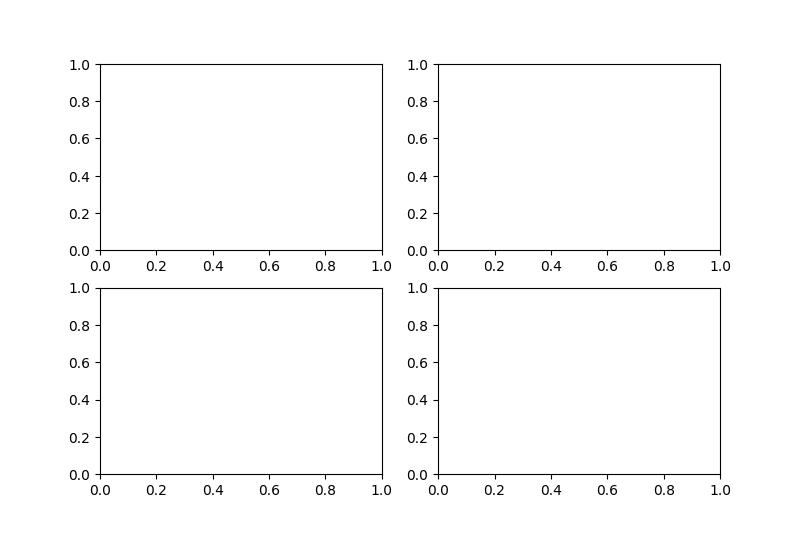

In [3]:
if "reward_design_fig" in locals():
    plt.close(reward_design_fig)
plt.ion()
# reward_design_fig = plt.figure(figsize=[7, 4])
# reward_design_ax = reward_design_fig.gca()
reward_design_fig, reward_design_ax = plt.subplots(2, 2, figsize=[8, 16/3])

## 1. Analyse Distance Reward

Define the distance-dependent reward function component $\text{reward\_fct\_dist}(x)$, which for a given distance between end-effector and target $x$ returns the respective reward. \
Also, define the range $[\text{xmin, xmax}]$ of distances that can be reached within an episode, as well as the maximum permissible distance to successfully reach/hit the target object $\text{xeps}$ (for visualisation only). \
\
_Optional:_ Define the expected distance $\text{xref}$ (for visualisation only).

**Note:** For a more sophisticated distance reward design approach (using Cubic Splines to obtain a reward function that satisfies custom constraints), run cells in Section 1B instead and then continue with Section 2.

In [4]:
## Define reward_fct_dist, xmin, xmax and xeps
_alpha = 1/10
reward_fct_dist = lambda x: (_alpha)*(np.exp(-(x/_alpha))-1)

xmin = 0
xmax = 0.5

xeps = 0.025  #"sufficient" distance to fulfill the pointing task (typically, this corresponds to the target radius); often, if dist<=xeps (for the first time), an additional bonus reward is given
xref = 0.3  #expected distance (optional)

In [5]:
## ymin, ymax, yeps and yref, as well as the x values to evaluate are automatically computed
_ymin = reward_fct_dist(xmin)
_ymax = reward_fct_dist(xmax)
_yeps = reward_fct_dist(xeps)
_yref = reward_fct_dist(xref)
_xeval = np.linspace(xmin, xmax)

Execute the following cell to fill the top left subplot in the figure above.

In [6]:
plt.sca(reward_design_ax[0, 0])
plt.gca().clear()

## plot reward function
plt.plot(_xeval, reward_fct_dist(_xeval))

## additionally plot chosen parameters
_xlim_before = plt.gca().get_xlim()
_ylim_before = plt.gca().get_ylim()
xticks = plt.gca().get_xticks()
# xticks = xticks[[0, -1]]
xticks = xticks[xticks!=0]
xticks_labels = xticks.tolist()
yticks = plt.gca().get_yticks()
# yticks = [yticks[-0], yticks[-1]]
yticks_labels = yticks.tolist()

plt.vlines(x=xeps, ymin=_ylim_before[0], ymax=_yeps, linestyle="--", color="green")
xticks = np.append(xticks, xeps)
xticks_labels.append(f"$x_{{eps}}={xeps:.2f}$")
plt.hlines(y=_yeps, xmin=_xlim_before[0], xmax=xeps, linestyle="--", color="green")
yticks = np.append(yticks, _yeps)
yticks_labels.append(f"$y_{{eps}}={_yeps:.2f}$")

plt.vlines(x=xmax, ymin=_ylim_before[0], ymax=_ymax, linestyle="--", color="red")
xticks = np.append(xticks, xmax)
xticks_labels.append(f"$x_{{max}}={xmax:.2f}$")
plt.hlines(y=_ymax, xmin=_xlim_before[0], xmax=xmax, linestyle="--", color="red")
yticks = np.append(yticks, _ymax)
yticks_labels.append(f"$y_{{max}}={_ymax:.2f}$")

plt.vlines(x=xref, ymin=_ylim_before[0], ymax=_yref, linestyle="--", color="orange")
xticks = np.append(xticks, xref)
xticks_labels.append(f"$x_{{ref}}={xref:.2f}$")
plt.hlines(y=_yref, xmin=_xlim_before[0], xmax=xref, linestyle="--", color="orange")
yticks = np.append(yticks, _yref)
yticks_labels.append(f"$y_{{ref}}={_yref:.2f}$")

_ticks_dict = dict(zip([np.round(i, 2) if isinstance(i, float) else i for i in xticks], xticks_labels))
xticks, xticks_labels = list(_ticks_dict.keys()), [f"{i:.2f}" if isinstance(i, float) else i for i in _ticks_dict.values()]
_ticks_dict = dict(zip([np.round(i, 2) if isinstance(i, float) else i for i in yticks], yticks_labels))
yticks, yticks_labels = list(_ticks_dict.keys()), [f"{i:.2f}" if isinstance(i, float) else i for i in _ticks_dict.values()]

plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xticks_labels)
plt.gca().set_xlim(_xlim_before)
plt.gca().set_yticks(yticks)
plt.gca().set_yticklabels(yticks_labels)
plt.gca().set_ylim(_ylim_before)
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.FormatStrFormatter('%.2f'))
# plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FormatStrFormatter('%.2f'))
# plt.gca().xaxis.set_major_locator(plt.matplotlib.ticker.AutoLocator()) #prune='lower'))
# plt.gca().yaxis.set_major_locator(plt.matplotlib.ticker.AutoLocator()) #prune='lower'))

## set xtick label colors
[i.set_color("green") if i._text.startswith("$x_{eps}") else i.set_color("red") if i._text.startswith("$x_{max}") else i.set_color("orange") if i._text.startswith("$x_{ref}") else i for i in plt.gca().get_xticklabels() if "$" in i._text]
[i.set_color("green") if i._text.startswith("$y_{eps}") else i.set_color("red") if i._text.startswith("$y_{max}") else i.set_color("orange") if i._text.startswith("$y_{ref}") else i for i in plt.gca().get_yticklabels() if "$" in i._text]

plt.gca().set_xlabel("Distance")
plt.gca().set_ylabel("Reward $r$")
plt.gca().set_title("Distance Reward Function Design", fontweight="bold")

# plt.gcf().autofmt_xdate()
plt.tight_layout()

## 2. Estimate Sequence of Distances During a Movement

The following cell allows to visualise the estimated distance reward during the course of a movement, for different scenarios. This is done as follows:
* For learned, successful movements, the distance is assumed to decrease either linearly or quadratically over time (linear/quadratic interpolation between initial distance $\text{xmax}$ and minimum distance $\text{xmin}$).
* In addition, the minimum and maximum distances $\text{xmax}$ and $\text{xmax}$, respectively, are plotted as constant lines, corresponding to (hypothetical) worst and best case scenarios (not moving towards the target at all / reaching the target instantaneously at the beginning of an episode).

To this end, define the estimated duration per movement $\text{estimated\_duration\_per\_movement}$ (defines the x-axis scaling, and is later used for predicting trade-offs between reward function components), as well as the number of evaluation points $\text{frame\_rate}$.

In [7]:
estimated_duration_per_movement = 1  #in seconds; defines time scaling of plot
frame_rate = 20  #in Hz; defines number of evaluation points

Execute the following cell to fill the top right subplot in the figure above.

In [8]:
plt.sca(reward_design_ax[0, 1])
plt.gca().clear()

# define times to evaluate reward at
_time = np.linspace(0, estimated_duration_per_movement, estimated_duration_per_movement*frame_rate)

# predict distances at evaluation times
_reward_dists_lin = np.linspace(0, 1, estimated_duration_per_movement*frame_rate)
_reward_dists_quad = 1-(1-_reward_dists_lin)**2

## OPTIONAL: plot time scaling
plt.gca().clear()
plt.plot(_time, xmax + (xmin - xmax) * _reward_dists_lin)  #linear
plt.plot(_time, xmax + (xmin - xmax) * _reward_dists_quad)  #quadratic
plt.gca().set_xlabel("Time (s)")
plt.gca().set_ylabel("Distance")

# predict rewards at evaluation times
_reward_vals_lin = reward_fct_dist(xmax + (xmin - xmax) * _reward_dists_lin)  #simplifying assumption: constant velocity
_reward_vals_quad = reward_fct_dist(xmax + (xmin - xmax) * _reward_dists_quad)
_reward_vals_worst = reward_fct_dist(xmax * np.ones_like(_reward_dists_lin))
_reward_vals_best = reward_fct_dist(xmin * np.ones_like(_reward_dists_lin))

## OPTIONAL: plot reward per time step
plt.gca().clear()
plt.scatter(_time, _reward_vals_lin, label=f"linear dist. scaling ($\sum r=${_reward_vals_lin.sum():2g})")  #linear
plt.scatter(_time, _reward_vals_quad, label=f"quadratic dist. scaling ($\sum r=${_reward_vals_quad.sum():2g})")  #quadratic
plt.scatter(_time, _reward_vals_worst, label=f"worst case ($\sum r=${_reward_vals_worst.sum():2g})", s=10, alpha=0.4)  #worst case (assuming that initial distance = maximum distance)
plt.scatter(_time, _reward_vals_best, label=f"ideal case ($\sum r=${_reward_vals_best.sum():2g})", s=10, alpha=0.4)  #ideal case (not possible usually)
plt.gca().set_xlabel("Time (s)")
plt.gca().set_ylabel("Reward $r$")

plt.legend()

plt.gca().set_title("Distance Reward Function Evaluation", fontweight="bold")

plt.tight_layout()

## 3. Analyse Effort Costs

Define the control space by setting the control dimension $\text{n\_controls}$ (i.e., the number muscles/motor actuators) and the minimum and maximum control vectors $\text{controlmin}$ and $\text{controlmax}$ (each as numpy arrays of shape ($\text{n\_controls}$,)), respectively.

You can also set $\text{estimated\_duration\_per\_movement}$ and $\text{frame\_rate}$, if you have not already done so above.

In [9]:
n_controls = 32  #control space dimension (number of muscles/motor actuators)
## n_controls can also be directly inferred from a sample control series defined below:
# n_controls = controls.iloc[0].shape[0]

controlmin = 0 * np.ones(n_controls)  #minimum control value
controlmax = 1 * np.ones(n_controls)  #maximum control value

estimated_duration_per_movement = 1  #in seconds; defines time scaling of plot (and should be consistent with value set for distance reward plot above!)
frame_rate = 20  #in Hz; defines number of evaluation points

Define the effort cost function by setting $\text{effort\_costs\_class}(x)$ to one of the following effort models (originally implemented in UitB, re-implemented in `effort_models.py` as standalone classes that do not require loading a MuJoCo model):
* $\text{Neural\_standalone}$
* $\text{CumulativeFatigue3CCr\_standalone}$
* $\text{ConsumedEndurance\_acts\_standalone}$
* _(or defining your own effort cost class in `effort_models.py`)_

Also, define a control cost weight $\text{effort\_costs\_weight}$.

In [10]:
## Requires uitb_tools to be installed as pip package
from uitb_reward_scaling.effort_models import Neural_standalone, CumulativeFatigue3CCr_standalone, ConsumedEndurance_acts_standalone

In [11]:
effort_costs_class = Neural_standalone  #options: Neural_standalone, CumulativeFatigue3CCr_standalone, ConsumedEndurance_acts_standalone
effort_costs_weight = 1e-3

The cell below allows to visualise the estimated effort during the course of a movement, for the following scenarios:
* Min/Max/Mean: Assumes that the controls at each time step correspond to the minimum/maximum/(algebraic) mean of the manually defined control space.
* Random: Assumes that the controls at each time step are uniformly random chosen from the manually defined control space _(stochastic simulation!)_.
* Optimal: Apply controls as observed from an UitB simulation, e.g., using a policy trained with a first guess of the reward function to be defined. This requires loading logged UitB data, as shown below. (Warning: controls are still randomly sampled from the set of all loaded control vectors _(stochastic simulation!)_.)

To this end, define the estimated duration per movement $\text{estimated\_duration\_per\_movement}$ (defines the x-axis scaling, and is later used for predicting trade-offs between reward function components), as well as the number of evaluation points $\text{frame\_rate}$.

**Load simulation controls and activations (used for "optimal" scenario)**

The following cell loads controls and activations from sample data we have generated with the trained "whacamole_constrained" simulated user from the [SIM2VR paper](https://doi.org/10.1145/3654777.3676452).
 
To use data logged from your own UitB simulation, set the simulation trajectory below using $\text{dirname\_simulation}$ and $\text{dirname\_simulation\_run}$.

In [12]:
## Requires uitb_tools to be installed as pip package
from uitb_evaluate.trajectory_data import TrajectoryData_RL

In [13]:
dirname_simulation = "sample_data/whacamole"
dirname_simulation_run = "8501/21-28-53-medium"

trajectories_SIMULATION = TrajectoryData_RL(dirname_simulation, dirname_simulation_run)

# TODO: update uitb_evaluate to ensure compatibility with SIM2VR simulation data (such that controls and activations can be directly computed by running trajectories_SIMULATION.preproces(), as originally intended)
controls = pd.Series(list(trajectories_SIMULATION.data.values())[0]["ctrl"], index=pd.Index(list(trajectories_SIMULATION.data.values())[0]["timestep"], name="timestep"), name="ctrl")
activations = pd.Series(list(trajectories_SIMULATION.data.values())[0]["act"], index=pd.Index(list(trajectories_SIMULATION.data.values())[0]["timestep"], name="timestep"), name="act")

1 episodes identified.


Execute the following cell to fill the bottom left subplot in the figure above.

In [14]:
_effort_costs_instance = effort_costs_class(n_controls, dt=1/frame_rate, weight=effort_costs_weight)
_effort_costs_fct = lambda i: (_effort_costs_instance.update(i), _effort_costs_instance.cost())[1]

plt.sca(reward_design_ax[1, 0])
plt.gca().clear()

# define times to evaluate reward at
_time = np.linspace(0, estimated_duration_per_movement, estimated_duration_per_movement*frame_rate)

# predict rewards at evaluation times
_effort_costs_instance.reset()
_rng = np.random.default_rng()
_effort_costs_random = np.array([_effort_costs_fct(_rng.uniform(low=controlmin, high=controlmax, size=n_controls)) for _ in range(len(_time))])
_effort_costs_instance.reset()
_effort_costs_mean = np.array([_effort_costs_fct(0.5*(controlmin + controlmax)) for _ in range(len(_time))])
_effort_costs_instance.reset()
_effort_costs_min = np.array([_effort_costs_fct(controlmin) for _ in range(len(_time))])
_effort_costs_instance.reset()
_effort_costs_max = np.array([_effort_costs_fct(controlmax) for _ in range(len(_time))])
_effort_costs_instance.reset()
# _effort_costs_optimal = np.array([_effort_costs_fct(np.vstack(controls.values).mean(axis=1)) for _ in range(len(_time))])
_rng = np.random.default_rng()
_effort_costs_optimal = np.array([_effort_costs_fct(_rng.choice(controls if effort_costs_class==Neural_standalone else activations)) for _ in range(len(_time))])

## OPTIONAL: plot reward per time step
plt.gca().clear()
plt.scatter(_time, _effort_costs_random, label=f"uniformly random ($\sum r_e=${_effort_costs_random.sum():2g})")  #uniformly random
plt.scatter(_time, _effort_costs_optimal, label=f"optimal ($\sum r_e=${_effort_costs_optimal.sum():2g})")  #controls selected by learned RL agent (not necessarily in this order!)
plt.scatter(_time, _effort_costs_mean, label=f"mean ($\sum r_e=${_effort_costs_mean.sum():2g})", s=10, alpha=0.4)  #mean activations
plt.scatter(_time, _effort_costs_min, label=f"min. ($\sum r_e=${_effort_costs_min.sum():2g})", s=10, alpha=0.4)  #zero activations
plt.scatter(_time, _effort_costs_max, label=f"max. ($\sum r_e=${_effort_costs_max.sum():2g})", s=10, alpha=0.4)  #maximum activations
plt.gca().set_xlabel("Time (s)")
plt.gca().set_ylabel("Effort costs $r_e$")

plt.legend()

plt.gca().set_title(f"Effort Cost Function Evaluation\n{effort_costs_class.__name__.split('_standalone')[0]}", fontweight="bold")

plt.tight_layout()

## 4. Plot Total Rewards

By running the following cell, you can plot the total rewards (distance reward minus effort costs) over time, for different scenarios.

Execute the following cell to fill the bottom right subplot in the figure above.

In [15]:
plt.sca(reward_design_ax[1, 1])
plt.gca().clear()

# define times to evaluate reward at
_time = np.linspace(0, estimated_duration_per_movement, estimated_duration_per_movement*frame_rate)

plt.gca().clear()
plt.scatter(_time, _reward_vals_lin, label=f"linear dist. scaling ($\sum r=${_reward_vals_lin.sum():2g})")  #linear
plt.scatter(_time, _reward_vals_quad, label=f"quadratic dist. scaling ($\sum r=${_reward_vals_quad.sum():2g})")  #quadratic
plt.scatter(_time, _reward_vals_worst, label=f"worst case ($\sum r=${_reward_vals_worst.sum():2g})", s=10, alpha=0.4)  #worst case (assuming that initial distance = maximum distance)
plt.scatter(_time, _reward_vals_best, label=f"ideal case ($\sum r=${_reward_vals_best.sum():2g})", s=10, alpha=0.4)  #ideal case (not possible usually)
plt.gca().set_xlabel("Time (s)")
plt.gca().set_ylabel("Reward $r$")

## OPTIONAL: plot reward per time step
plt.gca().clear()
plt.scatter(_time, _reward_vals_quad - _effort_costs_random, label=f"quadr. dist, random controls ($\sum (r - r_e)=${(_reward_vals_quad-_effort_costs_random).sum():2g})")  #quadr. time-to-distance mapping, random controls
plt.scatter(_time, _reward_vals_quad - _effort_costs_optimal, label=f"quadr. dist, optimal controls ($\sum (r - r_e)=${(_reward_vals_quad-_effort_costs_optimal).sum():2g})")  #quadr. time-to-distance mapping, controls selected by learned RL agent (not necessarily in this order!)
plt.scatter(_time, _reward_vals_best - _effort_costs_max, label=f"zero dist, max. controls ($\sum (r - r_e)=${(_reward_vals_best-_effort_costs_max).sum():2g})")  #maximum dist. reward, but maximum control costs
plt.scatter(_time, _reward_vals_worst - _effort_costs_min, label=f"max. dist, min. controls ($\sum (r - r_e)=${(_reward_vals_worst-_effort_costs_min).sum():2g})")  #maximum control costs, but minimum dist. reward
plt.scatter(_time, _reward_vals_best - _effort_costs_min, label=f"zero dist, min. controls ($\sum (r - r_e)=${(_reward_vals_best-_effort_costs_min).sum():2g})", s=10, alpha=0.4)  #maximum dist. reward and minimum control costs (optimum, if physically possible)
plt.gca().set_xlabel("Time (s)")
plt.gca().set_ylabel("Total reward $r - r_e$")

plt.legend()

plt.gca().set_title(f"Total Cost Function Evaluation\n(Effort Costs: {effort_costs_class.__name__.split('_standalone')[0]})", fontweight="bold")

plt.tight_layout()

## 5. Bonus Reward Design

**Rule of thumb**: A one-time bonus reward given at time step $n_{\text{early}}$ which results in early termination of an episode or at least in a target reset (i.e., it has a non-trivial effect on the total return per episode) needs to be chosen large enough to compensate for the opportunity cost of a longer lasting episode/target setup. This implies the following:
1. If the bonus reward successfully terminates the episode, i.e., the regular reward achieved for the "remaining" time steps until the maximum number of steps $N$ is reached equals zero, the bonus needs to be larger than the opportunity cost of the maximum regular reward $r_{\text{max}}$ that could have been achieved at each of these remaining time steps: 
$$r_{\text{bonus}}\geq\sum_{i=n_{\text{early}+1}}^{N}r_{\text{max}}=(N-n_{\text{early}})*r_{\text{max}}$$

2. If the success bonus does NOT terminate the episode but only resets the target, i.e., the regular reward for the "remaining" time steps until the maximum number of steps is reached can still be minimal, we need to take into account the difference between the maximum regular rewards that (hypothetically) could have been achieved at every remaining timestep (best-case continuing/non-bonus scenario) and the worst-case reward scenario that might be realized now instead (e.g., if the new target is spawned at maximum distance to the current position and the agent has no idea of how to get there): 
$$r_{\text{bonus}}+\sum_{i=n_{\text{early}+1}}^{N}r_{\text{min}}\geq\sum_{i=n_{\text{early}+1}}^{N}r_{\text{max}}\\\Leftrightarrow r_{\text{bonus}}\geq\sum_{i=n_{\text{early}+1}}^{N}(r_{\text{max}} - r_{\text{min}})=(N-n_{\text{early}})*(r_{\text{max}} - r_{\text{min}})$$

In both cases, we can thus define the bonus term either depending on the remaining time, i.e., $r_{\text{bonus}}(n_{\text{early}})$, or, to be on the safe side, use $n_{\text{early}}=0$ to obtain an upper bound for the minimum required bonus reward $r_{\text{bonus}}$.
For $n_{\text{early}}=0$, the lower bounds can be derived from the values given in the legend of the bottom right plot in the above figure.

## 1B. Appendix: Analyse Distance Reward with Cubic Splines

The following cell allows to define an own dense distance reward function using cubic Hermite splines.

In [81]:
import scipy

In [82]:
xmax = 0.8  #initial/maximum distance that can be typically reached; used to scale entire reward term relative to other rewards
_ymax = -0.1  #minimum negative reward; used to scale entire reward term relative to other rewards
xeps = 0.025  #"sufficient" distance to fulfill the pointing task (typically, this corresponds to the target radius); often, if dist<=xeps (for the first time), an additional bonus reward is given
_yeps = -0 #-0.05  #reward given at target boundary (WARNING: needs to be non-positive!); should be chosen between 10%*_ymax and _ymin=0
xref = 0.3 #"expected" distance; used to scale gradients of this reward term appropriately
_positive_only = True  #whether to ensure that all reward terms are positive (WARNING: requires that initial distance xmax is maximum reachable distance!)

## Optional parameters:
xmin = 0  #minimum distance
_ymin = 0  #reward at target
_dydxmin = 0  #reward gradient at target

The following cell incorporates the assumptions on the values of the gradient of the distance reward function at nodes $\text{xref}$, $\text{xeps}$ and $\text{xmax}$, as well as the distance reward at $\text{xref}$.

If $\text{\_positive\_only} = \text{True}$, the distance reward values at all nodes are adjusted to ensure non-negative distance rewards for any distances within the permitted range $[\text{xmin, xmax}]$.

In [ ]:
_dydxeps = (_yeps-_ymin)/(xeps-xmin)
_dydxmax = 0.1*(_ymax-_ymin)/(xmax-xmin)  #initial reward gradient
_alpha = (xref-xeps)/(xmax-xeps)  #0.5  #scale factor for linear interpolation between left secant (alpha=1) and right secant (alpha=0) -> if xref is closer to xeps, we need a more shallow gradient (i.e., alpha->0), if xref is closer to xmax, we need a steeper gradient (i.e., alpha->1) 

_yref = 0.5*(_ymin + _ymax)  #"expected"/"average" reward
# _yref = _yeps + (_dydxmax-_dydxeps)*(_ymax-_yeps)  #"expected"/"average" reward
# _yref = _yeps + (xref-xeps)/(xmax-xeps)*(_ymax-_yeps)  #"expected"/"average" reward

_dydxref = _alpha*(_yref-_yeps)/(xref-xeps) + (1-_alpha)*(_ymax-_yref)/(xmax-xref) #-0.5  #"expected"/"average" reward gradient
# _dydxref = (xmax-2*xref+xeps)*(_ymax-_yref)/(xmax-xref) #-0.5  #"expected"/"average" reward gradient

assert _ymax <= 10*_yeps and _yeps <= _ymin, f"'_yeps' should be chosen between 10%*_ymax={0.1*_ymax} and _ymin={_ymin}, but was set to _yeps={_yeps}."

if _positive_only:
    _ymin, _yeps, _yref, _ymax = (i-_ymax for i in (_ymin, _yeps, _yref, _ymax))

In [95]:
_x = np.array([xmin, xeps, xref, xmax])
_y = np.array([_ymin, _yeps, _yref, _ymax])
_dydx = np.array([_dydxmin, _dydxeps, _dydxref, _dydxmax])

_xeval = np.linspace(xmin, xmax)

### DEFINE REWARD FUNCTION ###
cs = scipy.interpolate.CubicHermiteSpline(x=_x, y=_y, dydx=_dydx)  #reward function r=cs(dist)
reward_fct_dist = cs

## check for invalid splines
_spline_localmins_x = cs.derivative().roots()[np.logical_and.reduce((cs.derivative().derivative()(cs.derivative().roots()) > 0, xmin <= cs.derivative().roots(), cs.derivative().roots() <= xmax))]
_spline_localmins_y = cs(_spline_localmins_x)
if len(_spline_localmins_x) > 0:
    print(f"Invalid parameter choice! Reward function has local minima at (x={_spline_localmins_x}, y={_spline_localmins_y})!")
# _cs_test_fig = plt.figure()
# _cs_test_fig.gca().scatter(_spline_localmins_x, _spline_localmins_y, s=100, marker="x", color="red")

Execute the following cell to fill the top left subplot in the figure above.

In [106]:
plt.sca(reward_design_ax[0, 0])
plt.gca().clear()

## plot reward function
plt.plot(_xeval, reward_fct_dist(_xeval))

## additionally plot chosen parameters
_xlim_before = plt.gca().get_xlim()
_ylim_before = plt.gca().get_ylim()
xticks = plt.gca().get_xticks()
# xticks = xticks[[0, -1]]
xticks = xticks[xticks!=0]
xticks_labels = xticks.tolist()
yticks = plt.gca().get_yticks()
# yticks = [yticks[-0], yticks[-1]]
yticks_labels = yticks.tolist()

plt.vlines(x=xeps, ymin=_ylim_before[0], ymax=_yeps, linestyle="--", color="green")
xticks = np.append(xticks, xeps)
xticks_labels.append(f"$x_{{eps}}={xeps:.2f}$")
plt.hlines(y=_yeps, xmin=_xlim_before[0], xmax=xeps, linestyle="--", color="green")
yticks = np.append(yticks, _yeps)
yticks_labels.append(f"$y_{{eps}}={_yeps:.2f}$")

plt.vlines(x=xmax, ymin=_ylim_before[0], ymax=_ymax, linestyle="--", color="red")
xticks = np.append(xticks, xmax)
xticks_labels.append(f"$x_{{max}}={xmax:.2f}$")
plt.hlines(y=_ymax, xmin=_xlim_before[0], xmax=xmax, linestyle="--", color="red")
yticks = np.append(yticks, _ymax)
yticks_labels.append(f"$y_{{max}}={_ymax:.2f}$")

plt.vlines(x=xref, ymin=_ylim_before[0], ymax=_yref, linestyle="--", color="orange")
xticks = np.append(xticks, xref)
xticks_labels.append(f"$x_{{ref}}={xref:.2f}$")
plt.hlines(y=_yref, xmin=_xlim_before[0], xmax=xref, linestyle="--", color="orange")
yticks = np.append(yticks, _yref)
yticks_labels.append(f"$y_{{ref}}={_yref:.2f}$")

_ticks_dict = dict(zip([np.round(i, 2) if isinstance(i, float) else i for i in xticks], xticks_labels))
xticks, xticks_labels = list(_ticks_dict.keys()), [f"{i:.2f}" if isinstance(i, float) else i for i in _ticks_dict.values()]
_ticks_dict = dict(zip([np.round(i, 2) if isinstance(i, float) else i for i in yticks], yticks_labels))
yticks, yticks_labels = list(_ticks_dict.keys()), [f"{i:.2f}" if isinstance(i, float) else i for i in _ticks_dict.values()]

plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xticks_labels)
plt.gca().set_xlim(_xlim_before)
plt.gca().set_yticks(yticks)
plt.gca().set_yticklabels(yticks_labels)
plt.gca().set_ylim(_ylim_before)
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.FormatStrFormatter('%.2f'))
# plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FormatStrFormatter('%.2f'))
# plt.gca().xaxis.set_major_locator(plt.matplotlib.ticker.AutoLocator()) #prune='lower'))
# plt.gca().yaxis.set_major_locator(plt.matplotlib.ticker.AutoLocator()) #prune='lower'))

## set xtick label colors
[i.set_color("green") if i._text.startswith("$x_{eps}") else i.set_color("red") if i._text.startswith("$x_{max}") else i.set_color("orange") if i._text.startswith("$x_{ref}") else i for i in plt.gca().get_xticklabels() if "$" in i._text]
[i.set_color("green") if i._text.startswith("$y_{eps}") else i.set_color("red") if i._text.startswith("$y_{max}") else i.set_color("orange") if i._text.startswith("$y_{ref}") else i for i in plt.gca().get_yticklabels() if "$" in i._text]

plt.gca().set_xlabel("Distance")
plt.gca().set_ylabel("Reward $r$")
plt.gca().set_title("Distance Reward Function Design", fontweight="bold")

# plt.gcf().autofmt_xdate()
plt.tight_layout()